In [1]:
import re
import tempfile
from pathlib import Path
from pyswmm.simulation import Simulation


# ──────────────────────────────────────────────────────────────────────────
# 1.  EDIT THE SCALE‑FACTOR IN  [INFLOWS]
# ──────────────────────────────────────────────────────────────────────────

def multiply_inflow_mfactor_no_baseline(
        inp_path: Path | str,
        ts_name: str,
        scale_factor: float,
        output_path: Path | None = None,
) -> Path:
    """Return a copy of *inp_path* with the Mfactor (last numeric token after TimeSeriesID)
       multiplied by *scale_factor*. Baseline is removed (i.e., not preserved or added)."""
    
    lines = Path(inp_path).read_text().splitlines()
    result = []
    in_inflows = False

    for line in lines:
        stripped = line.strip()

        if stripped.upper().startswith("[INFLOWS]"):
            in_inflows = True
            result.append(line)
            continue
        if in_inflows and stripped.startswith("[") and not stripped.upper().startswith("[INFLOWS]"):
            in_inflows = False

        if in_inflows and ts_name in stripped and not stripped.startswith(";"):
            parts = re.split(r"\s+", stripped)
            if len(parts) >= 4 and parts[2] == ts_name:
                # find all numeric fields after TimeSeriesID
                numeric_indices = []
                for i in range(3, len(parts)):
                    try:
                        float(parts[i])
                        numeric_indices.append(i)
                    except ValueError:
                        continue
                if numeric_indices:
                    mf_index = numeric_indices[-1]  # last numeric = Mfactor
                    mf = float(parts[mf_index])
                    parts[mf_index] = f"{mf * scale_factor:.4f}"
                    # keep only up to the modified Mfactor
                    parts = parts[:mf_index + 1]

                line = "    ".join(parts)
        result.append(line)

    out_path = Path(output_path or tempfile.mktemp(suffix=".inp"))
    out_path.write_text("\n".join(result))
    return out_path


# ──────────────────────────────────────────────────────────────────────────
# 2.  SUM FLOOD VOLUMES (ML) FROM THE REPORT
# ──────────────────────────────────────────────────────────────────────────
def parse_total_flood_volume(rpt_file):
    with open(rpt_file, "r", encoding="latin-1") as f:
        lines = f.readlines()

    start, end = None, None
    for i, line in enumerate(lines):
        if "Node Flooding Summary" in line:
            start = i + 7                 # header offset OK
        elif start and ("Outfall Loading Summary" in line or "END OF REPORT" in line):
            end = i
            break

    total_volume = 0.0
    for line in lines[start:end]:
        if not line.strip():
            continue
        parts = re.split(r"\s+", line.strip())
        try:
            total_volume += float(parts[-2])   # second‑to‑last = ML
        except (ValueError, IndexError):
            continue

    return total_volume



# ──────────────────────────────────────────────────────────────────────────
# 3.  RUN A MODEL AND RETURN TOTAL FLOOD VOLUME (ML)
# ──────────────────────────────────────────────────────────────────────────
def run_swmm_total_flood_ml(inp_path: Path) -> float:
    """
    Execute SWMM (PySWMM ≥ 2.0) and return the summed flood volume in ML.
    """
    rpt_path = Path(inp_path).with_suffix(".rpt")
    with Simulation(str(inp_path)) as sim:
        sim.execute()                  # PySWMM 2.x call
    return parse_total_flood_volume(rpt_path)


In [3]:
original_inp = Path(r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\SWMM\2025-05-16 INP files\Return_Periods_5_10_50\SWMM_Nakuru_wflow_forcing_reswmm_T_10_xsec_bar2.inp")



In [5]:
import pandas as pd
import tempfile

# List of scenarios and corresponding fraction CSVs
scenario_list = [
    "Reforestation_All_Subcatchments",
    "Terracing_All_Subcatchments",
    "Reforestation_and_Terracing_All_Subcatchments"
]

# Gauges to scale (must match columns in fraction CSV and inflow names in SWMM)
gauges = ["Q_2", "Q_3", "Q_4", "Q_8"]

# Return periods to process (must match index in fraction CSV)
return_periods = [10]

# Path to original SWMM .inp file
original_inp = Path(r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\SWMM\2025-05-16 INP files\Return_Periods_5_10_50\SWMM_Nakuru_wflow_forcing_reswmm_T_10_xsec_bar2.inp")

results = []

# Baseline simulation (no scaling)
for T in return_periods:
    # Use the original .inp file directly
    flood_ml = run_swmm_total_flood_ml(original_inp)
    results.append({
        "scenario": "Baseline",
        "return_period": T,
        "scale_factors": {gauge: 1.0 for gauge in gauges},
        "flood_volume_ML": flood_ml
    })
    print(f"Baseline | T={T} | scale_factors={{all 1.0}} ➜ {flood_ml:.2f} ML")

# NBS scenarios
for scenario in scenario_list:
    # Load fractions for this scenario
    fraction_df = pd.read_csv(f"fraction_{scenario}.csv", index_col=0)
    fraction_df.drop(columns=["Q_17"], inplace=True, errors="ignore")
    for T in return_periods:
        # Start from the original INP and apply all fractions for this return period
        mod_inp = original_inp
        # Use a temp file to chain modifications
        temp_inp = Path(tempfile.mktemp(suffix=".inp"))
        temp_inp.write_text(mod_inp.read_text())
        for gauge in gauges:
            ts_name = f"{gauge}_T_{T}"
            scale_factor = float(fraction_df.loc[T, gauge])
            temp_inp = multiply_inflow_mfactor_no_baseline(temp_inp, ts_name, scale_factor)
        # Run SWMM and get flood volume
        flood_ml = run_swmm_total_flood_ml(temp_inp)
        results.append({
            "scenario": scenario,
            "return_period": T,
            "scale_factors": {gauge: float(fraction_df.loc[T, gauge]) for gauge in gauges},
            "flood_volume_ML": flood_ml
        })
        print(f"{scenario} | T={T} | scale_factors={ {g: float(fraction_df.loc[T, g]) for g in gauges} } ➜ {flood_ml:.2f} ML")

# Convert results to DataFrame for analysis
df_results = pd.DataFrame(results)
display(df_results)


... SWMM Version 5.2.4
... Run CompleteBaseline | T=10 | scale_factors={all 1.0} ➜ 2640.08 ML

... SWMM Version 5.2.4
... Run CompleteReforestation_All_Subcatchments | T=10 | scale_factors={'Q_2': 0.98, 'Q_3': 0.99, 'Q_4': 0.98, 'Q_8': 0.98} ➜ 2611.21 ML

... SWMM Version 5.2.4
... Run CompleteTerracing_All_Subcatchments | T=10 | scale_factors={'Q_2': 0.99, 'Q_3': 0.98, 'Q_4': 0.95, 'Q_8': 0.97} ➜ 2615.60 ML

... SWMM Version 5.2.4
... Run CompleteReforestation_and_Terracing_All_Subcatchments | T=10 | scale_factors={'Q_2': 0.97, 'Q_3': 0.97, 'Q_4': 0.93, 'Q_8': 0.95} ➜ 2586.76 ML


,scenario,return_period,scale_factors,flood_volume_ML
0,Baseline,10,"{'Q_2': 1.0, 'Q_3': 1.0, 'Q_4': 1.0, 'Q_8': 1.0}",2640.080
1,Reforestation_All_Subcatchments,10,"{'Q_2': 0.98, 'Q_3': 0.99, 'Q_4': 0.98, 'Q_8':...",2611.213
2,Terracing_All_Subcatchments,10,"{'Q_2': 0.99, 'Q_3': 0.98, 'Q_4': 0.95, 'Q_8':...",2615.605
3,Reforestation_and_Terracing_All_Subcatchments,10,"{'Q_2': 0.97, 'Q_3': 0.97, 'Q_4': 0.93, 'Q_8':...",2586.760


In [7]:
import pandas as pd
import tempfile

# Path to the reservoirs scenario SWMM .inp file
reservoirs_inp = Path(r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\SWMM\2025-05-16 INP files\Return_Periods_5_10_50\2025-01-06 Interventions\SWWM_Nakuru_T_10_reservoirs_all_catchments.inp")

# Gauges and return periods as before
gauges = ["Q_2", "Q_3", "Q_4", "Q_5", "Q_6", "Q_7", "Q_8", "Q_14"]
return_periods = [10]

# --- 1. Reservoirs only (no scalefactors) ---
results_reservoirs_only = []
for T in return_periods:
    flood_ml = run_swmm_total_flood_ml(reservoirs_inp)
    results_reservoirs_only.append({
        "scenario": "Reservoirs_only",
        "return_period": T,
        "scale_factors": {gauge: 1.0 for gauge in gauges},
        "flood_volume_ML": flood_ml
    })
    print(f"Reservoirs_only | T={T} | scale_factors={{all 1.0}} ➜ {flood_ml:.2f} ML")
df_reservoirs_only = pd.DataFrame(results_reservoirs_only)
display(df_reservoirs_only)

# --- 2. Reservoirs + Reforestation_and_Terracing scalefactors ---
gauges_2 = ["Q_2", "Q_3", "Q_4", "Q_8"]
results_reservoirs_rt = []
fraction_df = pd.read_csv("fraction_Reforestation_and_Terracing_All_Subcatchments.csv", index_col=0)
fraction_df.drop(columns=["Q_17"], inplace=True, errors="ignore")

for T in return_periods:
    temp_inp = Path(tempfile.mktemp(suffix=".inp"))
    temp_inp.write_text(reservoirs_inp.read_text())
    for gauge in gauges_2:
        ts_name = f"{gauge}_T_{T}"
        scale_factor = float(fraction_df.loc[T, gauge])
        temp_inp = multiply_inflow_mfactor_no_baseline(temp_inp, ts_name, scale_factor)
    flood_ml = run_swmm_total_flood_ml(temp_inp)
    results_reservoirs_rt.append({
        "scenario": "Reservoirs+Reforestation_and_Terracing",
        "return_period": T,
        "scale_factors": {gauge: float(fraction_df.loc[T, gauge]) for gauge in gauges_2},
        "flood_volume_ML": flood_ml
    })
    print(f"Reservoirs+Reforestation_and_Terracing | T={T} | scale_factors={ {g: float(fraction_df.loc[T, g]) for g in gauges_2} } ➜ {flood_ml:.2f} ML")
df_reservoirs_rt = pd.DataFrame(results_reservoirs_rt)
display(df_reservoirs_rt)


... SWMM Version 5.2.4
... Run CompleteReservoirs_only | T=10 | scale_factors={all 1.0} ➜ 2277.31 ML


,scenario,return_period,scale_factors,flood_volume_ML
0,Reservoirs_only,10,"{'Q_2': 1.0, 'Q_3': 1.0, 'Q_4': 1.0, 'Q_5': 1....",2277.313



... SWMM Version 5.2.4
... Run CompleteReservoirs+Reforestation_and_Terracing | T=10 | scale_factors={'Q_2': 0.97, 'Q_3': 0.97, 'Q_4': 0.93, 'Q_8': 0.95} ➜ 2224.42 ML


,scenario,return_period,scale_factors,flood_volume_ML
0,Reservoirs+Reforestation_and_Terracing,10,"{'Q_2': 0.97, 'Q_3': 0.97, 'Q_4': 0.93, 'Q_8':...",2224.423


In [8]:
df_cumulative = pd.concat([df_results, df_reservoirs_only, df_reservoirs_rt], ignore_index=True)
# Remove the "Reservoirs+Reforestation_and_Terracing" scenario from the cumulative DataFrame
df_cumulative = df_cumulative[df_cumulative["scenario"] != "Reforestation_and_Terracing_All_Subcatchments"].reset_index(drop=True)
display(df_cumulative)



,scenario,return_period,scale_factors,flood_volume_ML
0,Baseline,10,"{'Q_2': 1.0, 'Q_3': 1.0, 'Q_4': 1.0, 'Q_8': 1.0}",2640.080
1,Reforestation_All_Subcatchments,10,"{'Q_2': 0.98, 'Q_3': 0.99, 'Q_4': 0.98, 'Q_8':...",2611.213
2,Terracing_All_Subcatchments,10,"{'Q_2': 0.99, 'Q_3': 0.98, 'Q_4': 0.95, 'Q_8':...",2615.605
3,Reservoirs_only,10,"{'Q_2': 1.0, 'Q_3': 1.0, 'Q_4': 1.0, 'Q_5': 1....",2277.313
4,Reservoirs+Reforestation_and_Terracing,10,"{'Q_2': 0.97, 'Q_3': 0.97, 'Q_4': 0.93, 'Q_8':...",2224.423


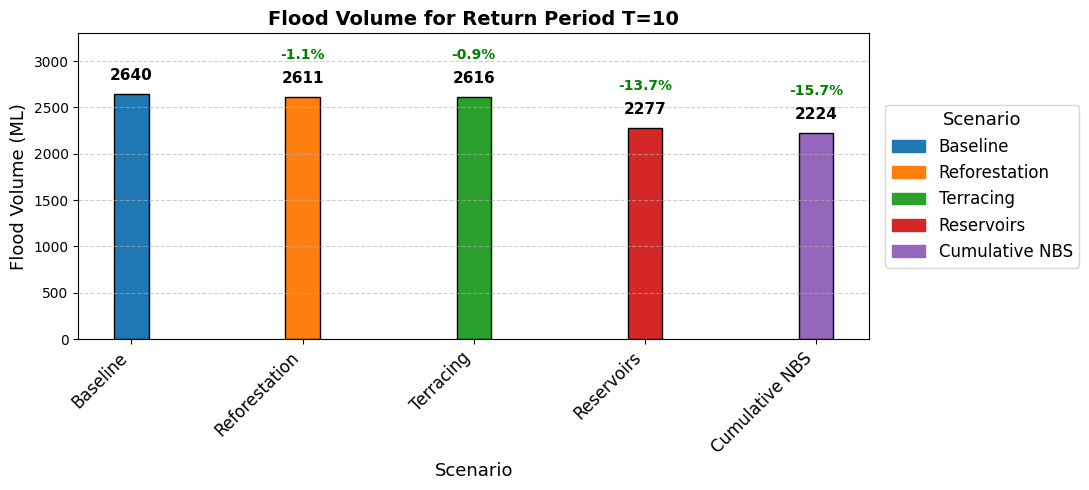

In [11]:
import matplotlib.pyplot as plt

# Mapping for clean scenario names
scenario_name_map = {
    "Baseline": "Baseline",
    "Reforestation_All_Subcatchments": "Reforestation",
    "Terracing_All_Subcatchments": "Terracing",
    "Reservoirs_only": "Reservoirs",
    "Reservoirs+Reforestation_and_Terracing": "Cumulative NBS"
}

plot_T = 10
df_plot = df_cumulative[df_cumulative["return_period"] == plot_T].copy()

# Apply the mapping to scenario names
df_plot["scenario_clean"] = df_plot["scenario"].map(scenario_name_map)
df_plot = df_plot[df_plot["scenario_clean"].notnull()]

scenarios = df_plot["scenario_clean"].unique()
colors = plt.cm.tab10.colors

# Get baseline value for percentage calculation
baseline_value = df_plot[df_plot["scenario_clean"] == "Baseline"]["flood_volume_ML"].values[0]

fig, ax = plt.subplots(figsize=(11, 5))

bar_positions = []
bar_labels = []
bar_colors = []
bar_values = []
bar_percents = []

width = 0.2
for i, scenario in enumerate(scenarios):
    value = df_plot[df_plot["scenario_clean"] == scenario]["flood_volume_ML"].values[0]
    bar_positions.append(i)
    bar_labels.append(scenario)
    bar_colors.append(colors[i % len(colors)])
    bar_values.append(value)
    if scenario == "Baseline":
        bar_percents.append("")  # No percentage for baseline
    else:
        percent = 100 * (baseline_value - value) / baseline_value
        bar_percents.append(f"-{percent:.1f}%")

bars = ax.bar(bar_positions, bar_values, color=bar_colors, width=width, edgecolor='black')

max_height = max(bar_values)
ax.set_ylim(top=max_height * 1.25)  # More space for labels

# Add value and percentage labels on top of bars
for bar, percent in zip(bars, bar_percents):
    height = bar.get_height()
    ax.annotate(f'{height:.0f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 8),  # 8 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    if percent:
        ax.annotate(percent,
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 25),  # further above
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, color='green', fontweight='bold')

ax.set_xticks(bar_positions)
ax.set_xticklabels(bar_labels, rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Flood Volume (ML)', fontsize=13)
ax.set_xlabel('Scenario', fontsize=13)
ax.set_title(f'Flood Volume for Return Period T={plot_T}', fontsize=14, fontweight='bold')

# Add grid for easier comparison
ax.yaxis.grid(True, linestyle='--', alpha=0.6)

# Add legend for scenarios (color-coded) outside the plot
from matplotlib.patches import Patch
legend_handles = [Patch(color=colors[i % len(colors)], label=bar_labels[i]) for i in range(len(scenarios))]
ax.legend(
    handles=legend_handles,
    title="Scenario",
    loc='center left',
    bbox_to_anchor=(1.01, 0.5),
    fontsize=12,
    title_fontsize=13
)

plt.tight_layout()
plt.savefig("flood_volume_comparison_cumulative_NBS_T10.png", dpi=300, bbox_inches='tight')
plt.show()
# Save the cumulative DataFrame to a CSV file
df_cumulative.to_csv("flood_volume_comparison_cumulative_NBS_T_10.csv", index=False)